In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import os, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from utils import *

import snowballstemmer
import nltk
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

PATH = os.getcwd()

nltk.download("stopwords")

plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
sns.set_style(style='whitegrid')

[nltk_data] Downloading package stopwords to /Users/js/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load data

In [2]:
df_raw = pd.read_csv(f'{PATH}/data/Airline-Sentiment-2-w-AA.csv', encoding='ISO-8859-1')
df_raw.shape

(14640, 20)

In [3]:
df_raw.sample(5)

_unit_id  _golden _unit_state  _trusted_judgments _last_judgment_at  \
6906   681457402    False   finalized                   3      2/25/15 7:38   
509    681449002    False   finalized                   3      2/25/15 4:42   
12477  681677625    False   finalized                   3     2/25/15 19:11   
379    681448868    False   finalized                   3      2/25/15 8:33   
2926   681452542    False   finalized                   3      2/25/15 6:59   

      airline_sentiment  airline_sentiment:confidence negativereason  \
6906           negative                        0.3523     Can't Tell   
509            negative                        0.3475     Can't Tell   
12477          negative                        1.0000   Lost Luggage   
379            positive                        1.0000            NaN   
2926           negative                        1.0000     Can't Tell   

       negativereason:confidence         airline airline_sentiment_gold  \
6906                      0.3523           Delta                    NaN   
509                       0.3475          United                    NaN   
12477                     0.3806        American                    NaN   
379                          NaN  Virgin America                    NaN   
2926                      0.6630          United                    NaN   

                name negativereason_gold  retweet_count  \
6906      borywrites                 NaN              0   
509          samidip                 NaN              0   
12477    sannimaarit                 NaN              0   
379    heatherbeckel                 NaN              0   
2926      riad_otoum                 NaN              0   

                                                    text tweet_coord  \
6906   See what you started now @nytimes RT @JetBlue:...         NaN   
509    @united Your ERI-ORD express connections are h...         NaN   
12477  @AmericanAir @Delta Maybe? Long trip, Late Fli...         NaN   
379    @VirginAmerica Just bought tix for ATX - Dalla...         NaN   
2926   @united I can tell you. Your airline has lost ...         NaN   

       tweet_created      tweet_id                 tweet_location  \
6906   2/23/15 18:08  5.700430e+17            The Bronx || Inwood   
509    2/24/15 11:36  5.703060e+17                       Erie, PA   
12477   2/24/15 2:51  5.701740e+17  Finn between Detroit & Toledo   
379     2/19/15 7:38  5.684340e+17                            ATX   
2926    2/20/15 9:44  5.688290e+17                 Louisville, KY   

                    user_timezone  
6906   Eastern Time (US & Canada)  
509    Eastern Time (US & Canada)  
12477                    Helsinki  
379    Central Time (US & Canada)  
2926                          NaN

## Sentiment

In [4]:
df_raw['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

### Sentiment per Airline

In [5]:
df_as = df_raw[['airline', 'airline_sentiment']].copy()
df_as.sample(5)

airline airline_sentiment
1585       United          negative
6394    Southwest          positive
14034    American          negative
10056  US Airways          negative
6737    Southwest          negative

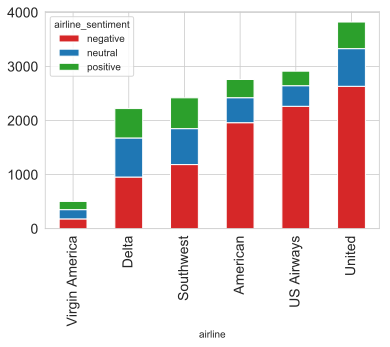

In [6]:
df_as = df_as.groupby(['airline','airline_sentiment']).size()
df_as_sort = df_as.groupby(level=0).sum().sort_values(ascending=True)
df_as.reindex(index=df_as_sort.index, level=0).unstack().plot(kind='bar', stacked=True, color=['C3', 'C0', 'C2'])
plt.show()

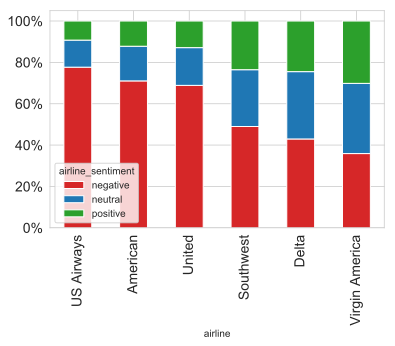

In [7]:
percentage = lambda x: 100 * x / x.sum()
negative = lambda x: x[x.name]['negative']

df_as = df_as.groupby(level=0).apply(percentage)
df_as_sort = df_as.groupby(['airline']).apply(negative).sort_values(ascending=False)
ax = df_as.reindex(index=df_as_sort.index, level=0).unstack().plot(kind='bar', stacked=True, color=['C3', 'C0', 'C2'])
ax.set_yticklabels(['{0}%'.format(int(x)) for x in ax.get_yticks()])
plt.show()

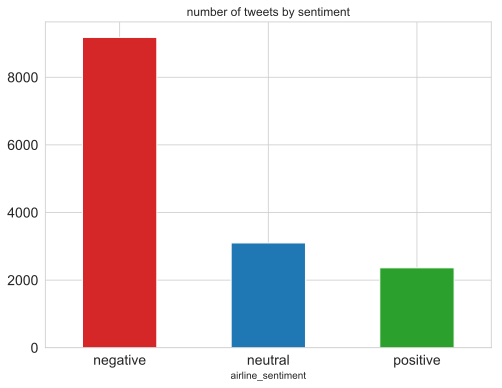

In [8]:
df = df_raw[['text', 'airline_sentiment']].copy()
df.groupby(['airline_sentiment']).count().plot(kind='bar', figsize=(8, 6), rot=0, legend=False, title='number of tweets by sentiment', color=[['C3', 'C0', 'C2']]);

In [9]:
pd.set_option('display.max_colwidth', -1)

## Preprocess data

Encoding categorical label classes into numeric values

In [10]:
le = LabelEncoder()
df['target'] = le.fit_transform(df['airline_sentiment'])

Text cleaning

In [11]:
ct = TextCleaner()
df['text_clean'] = ct.transform(df['text'])

Tokenizing

In [23]:
notk_regex = re.compile(f'[{string.punctuation}\W_]')
stop_words = set(stopwords.words('english')) | {'hi'}
stemmer = snowballstemmer.EnglishStemmer()

def tokenize(text_plain):
    tokens = notk_regex.split(text_plain)
    tokens = list(filter(lambda x: x not in stop_words, tokens))
    return stemmer.stemWords(tokens)

Train, test splitting

In [24]:
x_train, x_test, y_train, y_test = train_test_split(df['text_clean'].values, df['target'].values, test_size=0.25, random_state=0)

Td-idf (term frequency-inverse document frequency)

In [25]:
vect = TfidfVectorizer(strip_accents='unicode', tokenizer=tokenize, ngram_range=(1, 2), max_df=0.75, min_df=3, sublinear_tf=True)
tfidf_train = vect.fit_transform(x_train)
tfidf_test = vect.transform(x_test)

## Logistic Regression

In [26]:
m = LogisticRegression(C=4, dual=True, solver='liblinear')
m.fit(tfidf_train, y_train)

LogisticRegression(C=4, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

### Token importance

In [27]:
def get_tokens_coefs(vocab, coefs, n):
    coef_df = pd.DataFrame({'vocab': vocab, 'coef':coefs.reshape(-1)})
    return coef_df.sort_values('coef', ascending=False).reset_index(drop=True)[:n]

In [28]:
def plot_tokens_coefs(df, ax, label, c):
    df.sort_values('coef').plot.barh(legend=False, ax=ax, color=c)
    ax.set_yticklabels(df['vocab'].values.tolist()[::-1])
    ax.set_title(label);

In [29]:
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
sns.set_style(style='white')

0 negative
1 neutral
2 positive


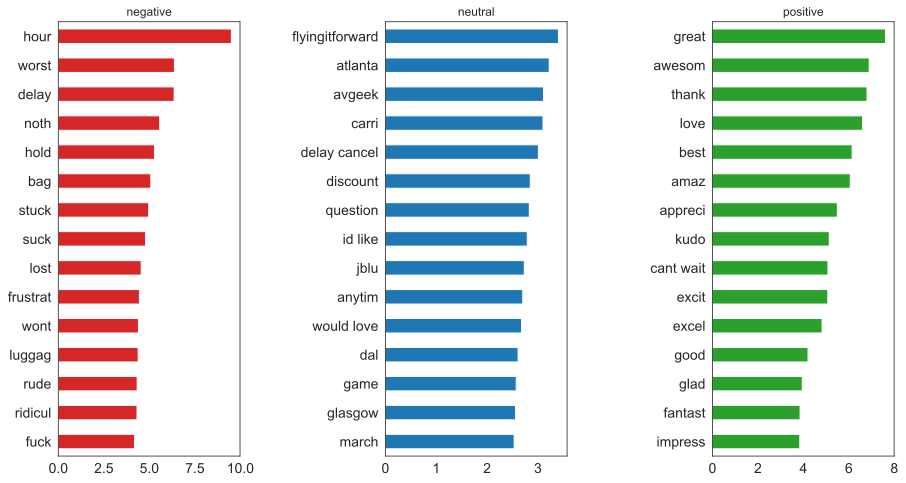

In [30]:
vocab = vect.get_feature_names()

n_coefs = 15
colors = ['C3', 'C0', 'C2']

fig, axs = plt.subplots(1, 3, figsize=(15, 8))
fig.subplots_adjust(wspace=0.8)

for i, l in enumerate(['negative', 'neutral', 'positive']):
    print(i, l)
    coef_df = get_tokens_coefs(vocab, m.coef_[i], n_coefs)
    plot_tokens_coefs(coef_df, axs[i], l, colors[i])